# ASTR 596: FDS Homework 6: Hunting for Exoplanets


### If you are watching Star Trek: Picard, then you might wonder about the "Admonition" - a warning/message left in an octuple planet system about past synthetic life in the Galaxy.

### [Ethan Siegel's Starts With a Bang blog has even covered it](https://www.forbes.com/sites/startswithabang/2020/03/19/is-star-trek-picards-hypothesized-octuple-star-system-really-possible/)

### The Kepler satellite has discovered many multi-planet systems. You can download artwork for some of them even at the [Exoplanet Travel Bureau](https://exoplanets.nasa.gov/alien-worlds/exoplanet-travel-bureau/)

<img src="figures/Kepler-186f_small.jpg">


### But is there a system with 8 planets??? In fact, there may be at least one - [Kepler 90](https://www.nytimes.com/2017/12/14/science/eight-planets-star-system.html). This along with most other Kepler planets, were not discovered through radial velocity measurements like our example in class (i.e. that nice parameteric model doesn't apply), but were rather discovered through transits - dips in the light of the star as the planet moves around it.


<img src="figures/Transiting-Exoplanet-Light-Curve.gif">

### You get to find 3 exoplanets in the Kepler-90 system with `gatspy`. 


### To get the Kepler data, you'll need the `lightkurve` package

> `conda install lightkurve`

### I've included some code to get the light curve, clean it and remove the NaNs, but not outliers (you can judge the wisdom of outlier removal when you are hunting for planets).


<hr>

#### Hints:

* `gatspy` has a `predict` method that you can use to get a model light curve for some period (you should need no more 3-5 terms). You might find it easier to remove the signal of each planet as you find it and work with the residual light curve to find the next.

* `lightkurve` has a bunch of useful [tutorials](https://docs.lightkurve.org/index.html)

* [The Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/index.html) might be of help

<hr>

# Happy (planet) hunting!

In [2]:
%matplotlib inline
import lightkurve as lk
import gatspy

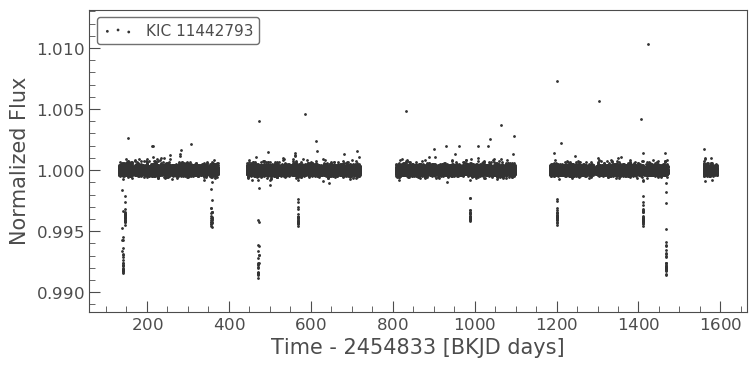

In [3]:
lcfs = lk.search_lightcurvefile('Kepler-90', mission='Kepler').download_all()

def squelch_rednoise(lc):
    corrected_lc = lc.normalize().flatten(window_length=51)
    return corrected_lc

stitched_lc = lcfs.PDCSAP_FLUX.stitch(corrector_func=squelch_rednoise)
clc = stitched_lc.remove_nans()

clc.scatter();

In [12]:
from matplotlib import pyplot as plt
import numpy as np

## Planet 1
## I am going to use periodogram following lightkurve tutorial:

`period` contains 850623 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


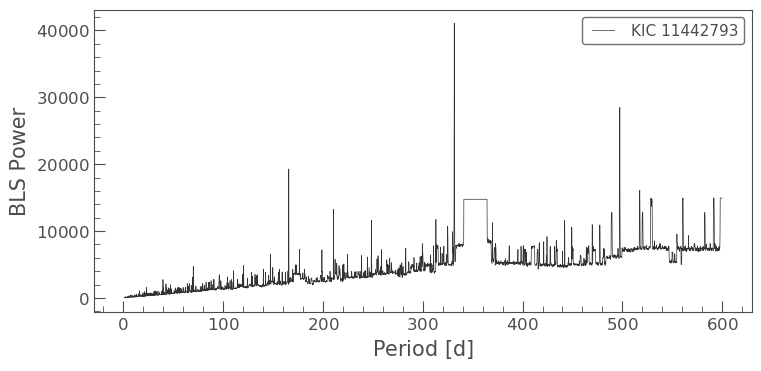

In [39]:
periodogram = clc.to_periodogram(method="bls", period=np.arange(1, 600, 0.2))
periodogram.plot()

In [108]:
period_p1 = periodogram.period_at_max_power
t0_p1     = periodogram.transit_time_at_max_power
print('Best fit period: {:.3f}'.format(period_p1))
print('Best fit t0: {:.3f}'.format(t0_p1))

Best fit period: 331.600 d
Best fit t0: 140.487


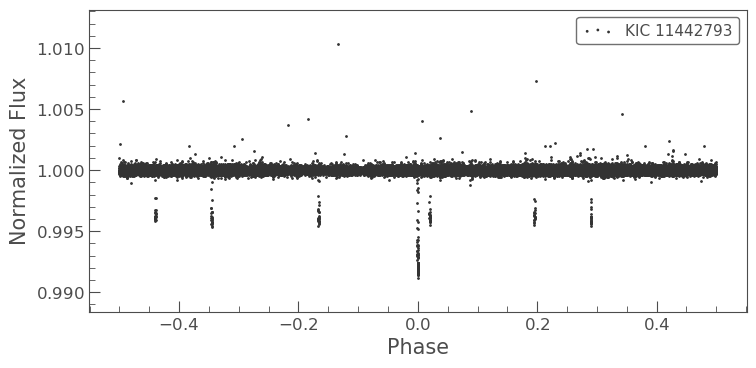

In [109]:
ax = clc.fold(period=period_p1, t0=t0_p1).scatter()

(-0.015, 0.015)

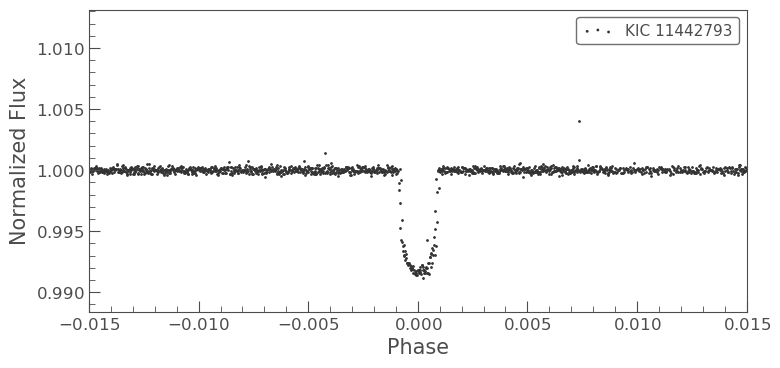

In [110]:
ax = clc.fold(period=period_p1, t0=t0_p1).scatter()
ax.set_xlim([-1.5e-2,1.5e-2])

## I've tried using gatspy to model the lightcurve, but it seems that gatspy can only predict sinusoidal curve

In [75]:
from gatspy import datasets, periodic

model = periodic.LombScargleFast(fit_period=False)
model.optimizer.period_range = (310, 330)

model.fit(clc.time, clc.flux,)

model.best_period

Finding optimal frequency:
 - Estimated peak width = 0.00431
 - Using 5 steps per peak; omega_step = 0.000861
 - User-specified period range:  3e+02 to 3.3e+02
 - Computing periods at 3 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


341.26570874846556

(0.9998, 1.0002)

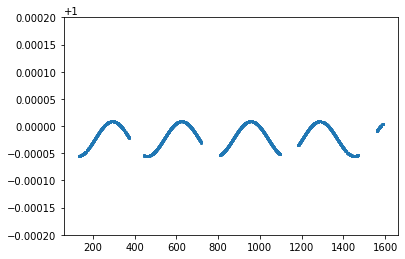

In [88]:
mag_fit = model.predict(clc.time, period=best_fit_period.value)

plt.scatter(clc.time, mag_fit, s=3, linewidth=0)

plt.ylim([0.9998,1.0002])

## So I am going to flag the transit of the known planets so I can find the next one.

### Remove the transit of Planet 1

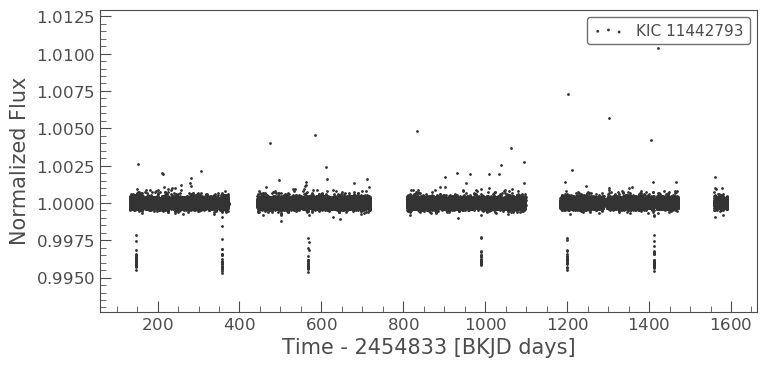

In [120]:
# helper function to determine where is the transit
def isTransit(t,period,t0,dt):
    phase = ((t-t0)/period)
    phase = phase - np.round(phase)
    return np.abs(phase) < (dt/2/period)

flag = isTransit(clc.time,period_p1,t0_p1,2)

clc_r1 = clc.copy()
clc_r1.flux[flag] = np.nan
clc_r1 = clc_r1.remove_nans()
clc_r1.scatter()

## Planet 2

`period` contains 850623 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


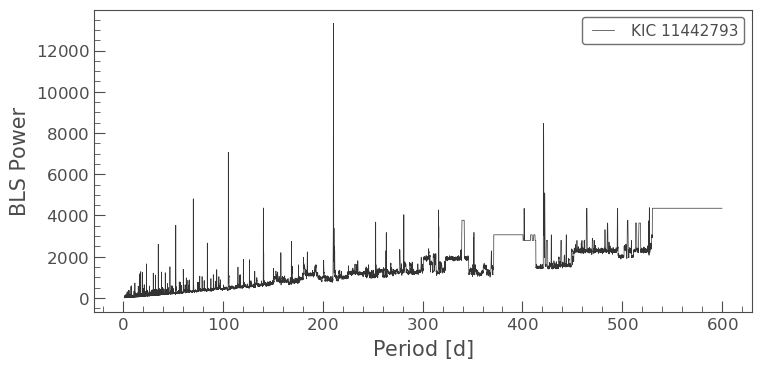

In [154]:
periodogram = clc_r1.to_periodogram(method="bls", period=np.arange(1, 600, 0.05))
periodogram.plot()

In [155]:
period_p2 = periodogram.period_at_max_power
t0_p2     = periodogram.transit_time_at_max_power
print('Best fit period: {:.3f}'.format(period_p2))
print('Best fit t0: {:.3f}'.format(t0_p2))

Best fit period: 210.600 d
Best fit t0: 147.062


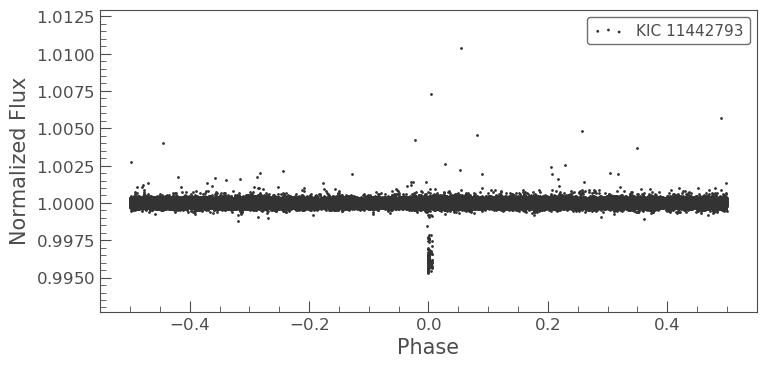

In [140]:
ax = clc_r1.fold(period=period_p2, t0=t0_p2).scatter()

(-0.013, 0.013)

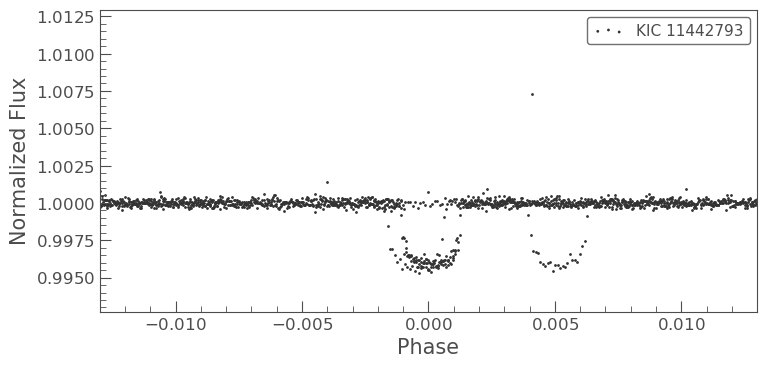

In [148]:
ax = clc_r1.fold(period=period_p2, t0=t0_p2).scatter()
ax.set_xlim([-1.3e-2,1.3e-2])

### Remove the transit of Planet 2

### In order to remove that misalighed transit, we have to use a slight larger dt of 3 days.

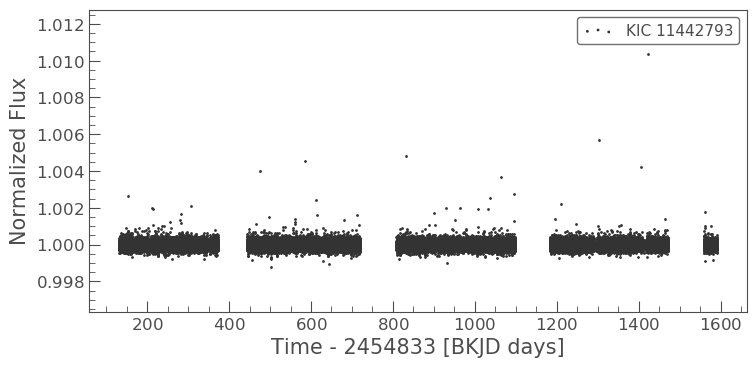

In [146]:
flag = isTransit(clc_r1.time,period_p2,t0_p2,3)

clc_r2 = clc_r1.copy()

clc_r2.flux[flag] = np.nan
clc_r2 = clc_r2.remove_nans()
clc_r2.scatter()

(-0.013, 0.013)

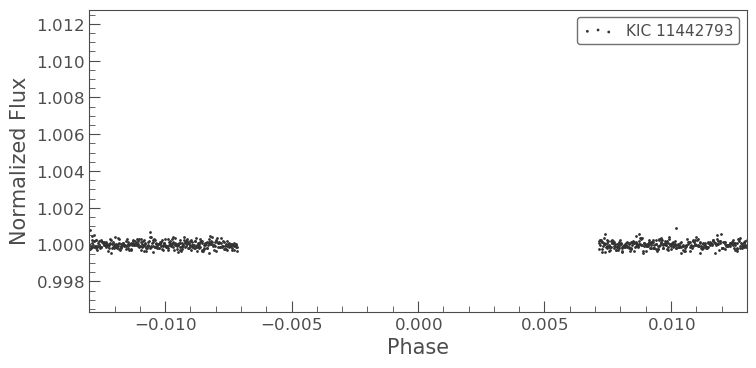

In [149]:
ax = clc_r2.fold(period=period_p2, t0=t0_p2).scatter()
ax.set_xlim([-1.3e-2,1.3e-2])

## Planet 3

`period` contains 850623 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


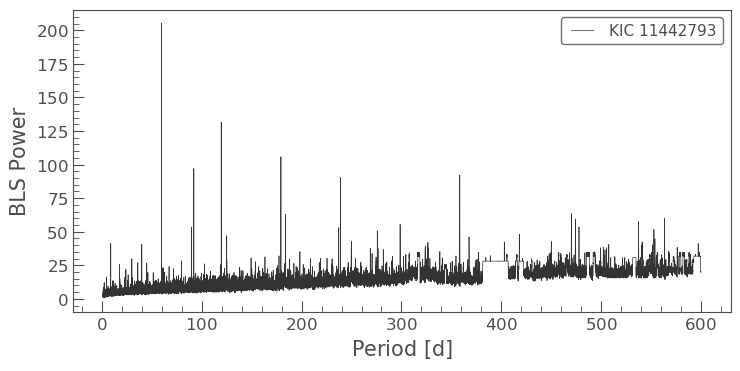

In [158]:
periodogram = clc_r2.to_periodogram(method="bls", period=np.arange(1, 600, 0.02))
periodogram.plot()

In [159]:
period_p3 = periodogram.period_at_max_power
t0_p3     = periodogram.transit_time_at_max_power
print('Best fit period: {:.3f}'.format(period_p3))
print('Best fit t0: {:.3f}'.format(t0_p3))

Best fit period: 59.740 d
Best fit t0: 39.457


(0.997, 1.003)

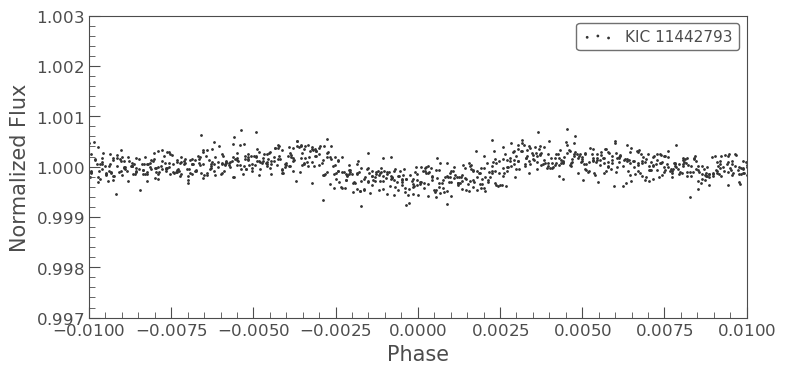

In [170]:
ax = clc_r2.fold(period=period_p3, t0=t0_p3).scatter()
ax.set_xlim([-1e-2,1e-2])
ax.set_ylim([0.997,1.003])

### All three planets are found using periodogram! Their periods are shown below:


In [168]:
print('Planet 1:')
print('Best fit period: {:.3f}'.format(period_p1))
print('Best fit t0: {:.3f}\n'.format(t0_p1))
print('Planet 2:')
print('Best fit period: {:.3f}'.format(period_p2))
print('Best fit t0: {:.3f}\n'.format(t0_p2))
print('Planet 3:')
print('Best fit period: {:.3f}'.format(period_p3))
print('Best fit t0: {:.3f}\n'.format(t0_p3))

Planet 1:
Best fit period: 331.600 d
Best fit t0: 140.487

Planet 2:
Best fit period: 210.600 d
Best fit t0: 147.062

Planet 3:
Best fit period: 59.740 d
Best fit t0: 39.457



### What about Planet 4?

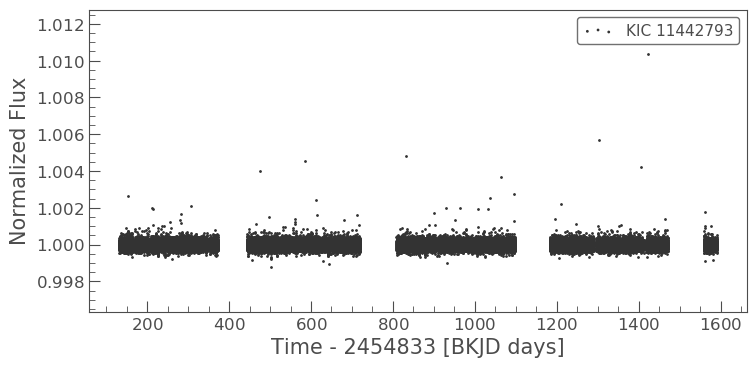

In [176]:
flag = isTransit(clc_r2.time,period_p3,t0_p3,0.7)

clc_r3 = clc_r2.copy()

clc_r3.flux[flag] = np.nan
clc_r3 = clc_r3.remove_nans()
clc_r3.scatter()

(0.997, 1.003)

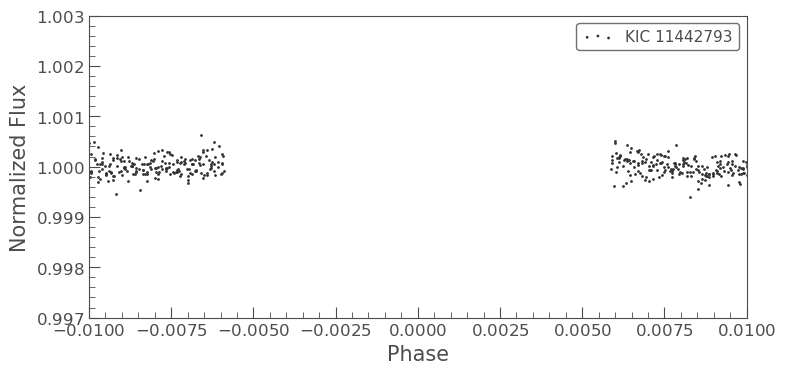

In [177]:
ax = clc_r3.fold(period=period_p3, t0=t0_p3).scatter()
ax.set_xlim([-1e-2,1e-2])
ax.set_ylim([0.997,1.003])

`period` contains 850623 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


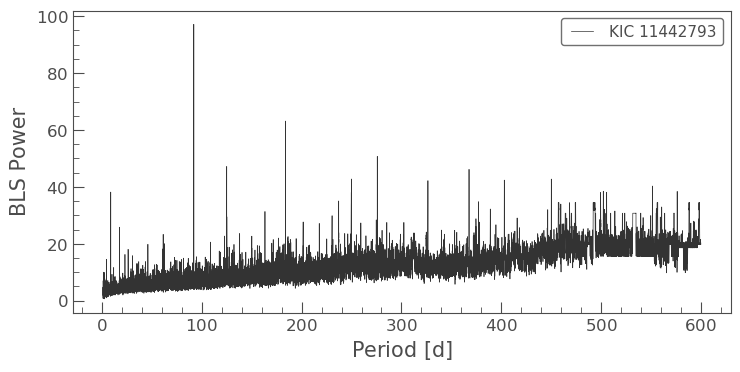

In [178]:
periodogram = clc_r3.to_periodogram(method="bls", period=np.arange(1, 600, 0.02))
periodogram.plot()

In [180]:
period_p4 = periodogram.period_at_max_power
t0_p4     = periodogram.transit_time_at_max_power
print('Best fit period: {:.3f}'.format(period_p4))
print('Best fit t0: {:.3f}'.format(t0_p4))

Best fit period: 91.940 d
Best fit t0: 42.322


(0.997, 1.003)

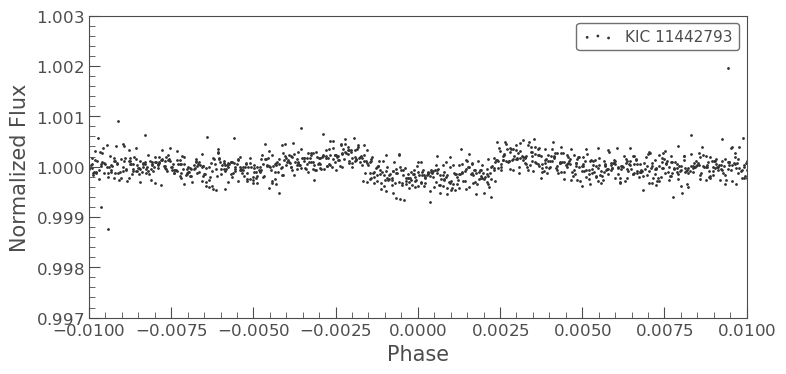

In [181]:
ax = clc_r3.fold(period=period_p4, t0=t0_p4).scatter()
ax.set_xlim([-1e-2,1e-2])
ax.set_ylim([0.997,1.003])

### So yes! There is a fourth planet!